<a href="https://colab.research.google.com/github/iangama/Desafio-6/blob/main/Desafio_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Neste projeto, iremos aplicar os conhecimentos de clustering para criar um sistema de agrupamento de perfis de clientes para um e-commerce.

# Contexto

Uma empresa está de e-commerce está buscando entender
melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing.

A empresa deseja identificar padrões e características em
comum entre os clientes, como:
- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras

# Sobre os dados

Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.

- *InvoiceNo*: Identificação da transação Int
- *StockCode*: Código de estoque do produto String
- *Description*: Descrição do produto String
- *Quantity*: Quantidade de produtos por transação Int
- *InvoiceDate*: Data da transação Datetime
- *UnitPrice*: Preço unitário do produto Float
- *CustomerID*: Identificação do cliente Int
- *Country*: País de origem da transação String

# Etapa 01) Análise exploratória dos dados

In [ ]:
# importa o drive
from google.colab import drive

# monta o google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importa bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# pasta onde os dados foram salvos no Google Drive
caminho_drive = '/content/drive/MyDrive/'
caminho_dados = 'Projetos/Análises/Ian G 2023/'
nome_arquivo = 'data_desafio_6.csv'
caminho = caminho_drive + caminho_dados + nome_arquivo

# lê o dataset
df = pd.read_csv(caminho, sep=',', encoding='latin')

In [ ]:
# exibe primeiras 5 linhas do dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# exibe informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# exibe estatísticas descritivas do dataset
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Existem valores outliers nas colunas de quantidade e preço unitário do produto, pois os valores mínimo e máximo são discrepantes em comparação aos dados.

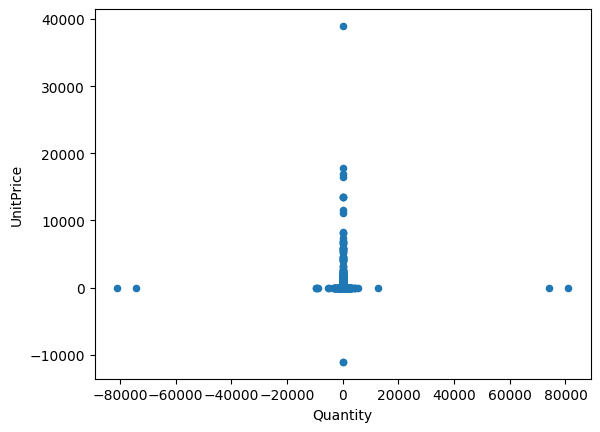

In [ ]:
# plota gráfico de dispersão entre quantidade e preço unitário
df.plot.scatter(x='Quantity', y='UnitPrice')
plt.show()

Considerando o gráfico, vamos definir três tipos de outliers nas colunas de quantidade e preço unitário:
- valores negativos
- quantidade do item maior que 10.000
- preço unitário maior que 5.000

In [ ]:
# conta outliers menores que 0
df[(df['Quantity'] < 0) | (df['UnitPrice'] < 0)].shape[0]

10626

In [ ]:
# conta outliers em que a quantidade do item é superior a 10.000
# e preço unitário é maior que 5.000
df[(df['Quantity'] > 10000) | (df['UnitPrice'] > 5000)].shape[0]

34

In [ ]:
# conta valores nulos em cada coluna
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# conta linhas duplicadas
df.duplicated().sum()

5268

# Etapa 02) Pré-processamento dos dados

In [ ]:
# remove valores nulos
df.dropna(subset=['Description','CustomerID'], inplace=True)

In [ ]:
# remove linhas duplicadas
df.drop_duplicates(inplace=True)

In [ ]:
# corrige o tipo de dado dos códigos de identificação da transação e do cliente
# de numérico para texto
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['CustomerID'] = df['CustomerID'].astype(str)

# corrige o tipo de dado das datas de transação para data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# remove os outliers
df.drop(df[(df['Quantity'] < 0) | (df['UnitPrice'] < 0)].index, inplace=True)
df.drop(df[(df['Quantity'] > 10000) | (df['UnitPrice'] > 5000)].index, inplace=True)

In [ ]:
# seleciona variáveis relevantes para o modelo
# calcula o valor total
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# total
am = df.groupby('CustomerID')['TotalAmount'].sum().reset_index()
am.columns=['CustomerID', 'Amount']

# frequencia
fr = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
fr.columns=['CustomerID', 'Frequency']

# faz o merge dos dois datasets
df_rfm = pd.merge(am, fr, on='CustomerID', how='inner')
df_rfm

,CustomerID,Amount,Frequency
0,12347.0,4310.00,182
1,12348.0,1797.24,31
2,12349.0,1757.55,73
3,12350.0,334.40,17
4,12352.0,2506.04,85
...,...,...,...
4332,18280.0,180.60,10
4333,18281.0,80.82,7
4334,18282.0,178.05,12
4335,18283.0,2045.53,721


In [ ]:
# seleciona variáveis numéricas
df_numeric = df_rfm.copy()
df_numeric = df_numeric[['Amount','Frequency']]

In [ ]:
# normaliza os dados
scaler = StandardScaler()
X_norm = scaler.fit_transform(df_numeric)

# Etapa 03) Selecione um algoritmo de clusterização

O método K-means foi usado nesta etapa. É um dos algoritmos mais usados para clusterização, que separa os pontos do conjunto de dados em diferentes clusters com base nas distâncias entre pontos.

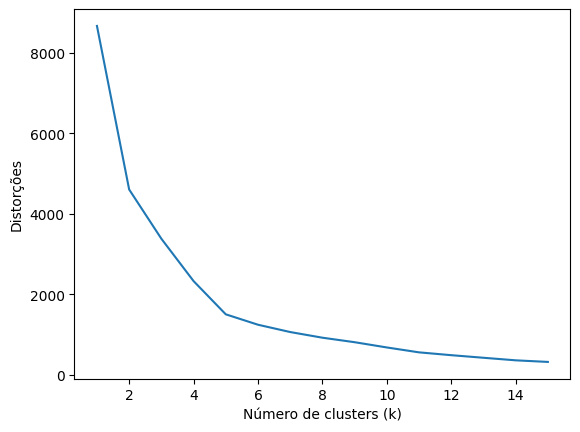

In [ ]:
# encontra a quantidade ideal de clusters usando os método de Elbow
distortions = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(X_norm)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 16), distortions)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Distorções')
plt.show()

No método de Elbow, o valor ideal para o número de clusters (k) é o ponto em que ocorre a inflexão da curva no gráfico. Como pode ser visto no gráfico, o número de clusters em que ocorre a inflexão da curve é k = 4. Portanto, foi selecionado k = 4.

In [ ]:
# implementa o algoritmo
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init='auto', random_state = 42)
y_cluster = kmeans.fit_predict(X_norm)

In [ ]:
# cria dataset com dados normalizados e clusters
df_cluster = pd.DataFrame(X_norm, columns=['Amount','Frequency'])
df_cluster['Cluster'] = y_cluster
df_cluster.head()

,Amount,Frequency,Cluster
0,0.271901,0.405471,0
1,-0.022673,-0.264054,0
2,-0.027326,-0.077829,0
3,-0.194163,-0.326129,0
4,0.060421,-0.024621,0


# Etapa 04) Analise os clusters obtidos

In [ ]:
# número de clientes em cada cluster
df_cluster['Cluster'].value_counts()

0    4299
2      31
1       4
3       3
Name: Cluster, dtype: int64

In [ ]:
# valores médios de total e frequência por cluster
df_cluster.groupby('Cluster')[['Amount','Frequency']].mean()

,Amount,Frequency
Cluster,,
0,-0.065299,-0.045946
1,8.044593,24.951761
2,5.263434,2.783779
3,28.459130,3.806303


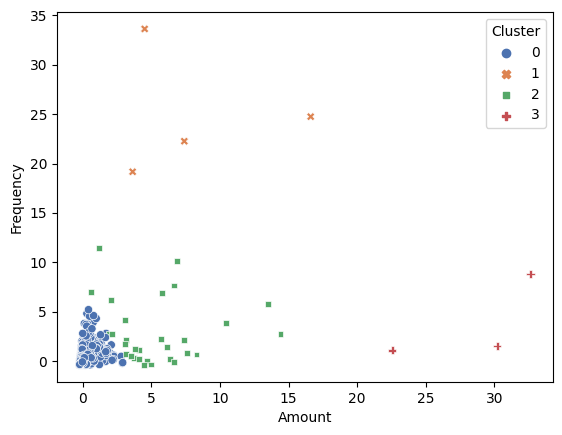

In [ ]:
# plota gráficos
sns.scatterplot(data=df_cluster, x='Amount', y='Frequency', hue='Cluster', style='Cluster', palette='deep')
plt.show()

Os principais resultados desta etapa são:

- A maior parte dos clientes está localizada no Cluster 0
- No Cluster 0, os clientes possuem baixa frequência e baixo total
- No Cluster 1, os clientes possuem alta frequência e médio total
- No Cluster 2, os clientes possuem média frequência e médio total
- No Cluster 3, os clientes possuem média frequência e alto total

# Etapa 05) Interpretação dos resultados obtidos

O perfil de compras dos clientes pode ser descrito da seguinte forma:

- A maior parte dos clientes compra poucas vezes e em baixa quantidades, representando o Cluster 0
- Um grupo menor de clientes compra com frequência e em quantidades relativamente maiores que a maioria, no caso do Cluster 2
- Um pequeno grupo de clientes compra com alta frequência e a quantidade comprada pode variar a depender do cliente, representando o Cluster 1
- Outro pequeno grupo de clientes compra em altas quantidades e com frequências médias que podem variar a depender do cliente, no caso do Cluster 3

Estes resultados podem fornecer informações para a empresa personalizar as campamnhas de marketing, pois os perfis dos clientes foram segmentados em diferentes grupos.

Como ações sugeridas, a empresa pode dedicar esforços em campanhas para o público geral (Cluster 0), bucando fazer com que estes clientes comprem mais vezes e em maiores quantidades.